In [46]:
import os
import sys
sys.path.append("..")
import phytebyte as pb
from phytebyte.bioactive_cmpd.sources import chembl

As a part of the model training process, positive examples will be clustered in order to understand whether there are distinct sets of bioactive compound "classes". These clusters will be modeled separately and the results joined at the end so as to not create conflicting signals in the model training process.

Choice of clustering algorithm: there is a good (though biased) discussion of potential clustering algorithms [here](http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html), which steps through some of the main characteristics that are desirable in an algorithm and compares pros/cons. 

We do not necessarily have a good idea *a priori* as to what properties our fingerprint data have or what shapes the compound sets are likely to form in high-dimensional space. However we do know a few things:
* Though we may be able to perform checks using prior knowledge on input drug sets, we don't want to assume for this step that we know the number of clusters, so any method we choose should have some ability to "help" with this decision. On a related note, we should be able to extract some sort of metric as to whether there are multiple clusters at all.
* The feature space will typically be at least the size of an FP2 fingerprint (1024 bits), so speed could be a limiting factor.

Given the second point, we can remove slow methods from our search altogether. The HDBSCAN fellows (of the post linked above) have conveniently benchmarked the performance of the same set of Python clustering implementations [here](http://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html#). At least in terms of scaling with the number of data points (note: not our limitation here), only three methods do reasonably well: K-means variants, agglomerative clustering variants, and DBSCAN variants.

Unapologetically stealing their code and modifying it somewhat to compare feature sizes rather than data point numbers, we have the following clustering benchmark algorithm, which generates and uses toy datasets with Gaussian clusters:

In [47]:
import numpy as np
import pandas as pd
import sklearn.cluster
import sklearn.datasets
import fastcluster
import hdbscan
import time


def benchmark_algorithm(dataset_dimensions, cluster_function, function_args, function_kwds,
                        dataset_size=500, dataset_n_clusters=3, max_time=10, sample_size=2):

    # Initialize the result with NaNs so that any unfilled entries
    # will be considered NULL when we convert to a pandas dataframe at the end
    result = np.nan * np.ones((len(dataset_dimensions), sample_size))
    for index, dataset_dimension in enumerate(dataset_dimensions):
        for s in range(sample_size):
            # Use sklearns make_blobs to generate a random dataset with specified size
            # dimension and number of clusters
            data, labels = sklearn.datasets.make_blobs(n_samples=dataset_size,
                                                       n_features=dataset_dimension,
                                                       centers=dataset_n_clusters)

            # Start the clustering with a timer
            start_time = time.time()
            cluster_function(data, *function_args, **function_kwds)
            time_taken = time.time() - start_time

            # If we are taking more than max_time then abort -- we don't
            # want to spend excessive time on slow algorithms
            if time_taken > max_time:
                result[index, s] = time_taken
                return pd.DataFrame(np.vstack([dataset_dimension.repeat(sample_size),
                                               result.flatten()]).T, columns=['x','y'])
            else:
                result[index, s] = time_taken

    # Return the result as a dataframe for easier handling with seaborn afterwards
    return pd.DataFrame(np.vstack([dataset_dimensions.repeat(sample_size),
                                   result.flatten()]).T, columns=['x','y'])

We can then examine the performance of these algorithms in relation to each other in terms of scaling as the feature space grows.

In [48]:
dataset_feature_sizes = np.arange(10, 1000, 100)

kmeans = sklearn.cluster.KMeans(3)
k_means_data = benchmark_algorithm(dataset_feature_sizes, kmeans.fit, (), {})

agglomerative = sklearn.cluster.AgglomerativeClustering(10)
agg_data = benchmark_algorithm(dataset_feature_sizes,
                               agglomerative.fit, (), {}, sample_size=4)

fastclust_data = benchmark_algorithm(dataset_feature_sizes,
                                     fastcluster.linkage_vector, (), {})

dbscan = sklearn.cluster.DBSCAN(eps=1.25)
dbscan_data = benchmark_algorithm(dataset_feature_sizes, dbscan.fit, (), {})

hdbscan_ = hdbscan.HDBSCAN()
hdbscan_data = benchmark_algorithm(dataset_feature_sizes, hdbscan_.fit, (), {})

Text(0,0.5,'Clustering run time (s)')

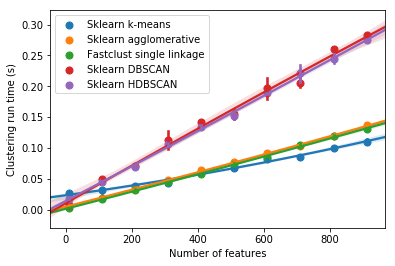

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.regplot(x='x', y='y', data=k_means_data, order=2, label="Sklearn k-means", x_estimator=np.mean)
sns.regplot(x='x', y='y', data=agg_data, order=2, label="Sklearn agglomerative", x_estimator=np.mean)
sns.regplot(x='x', y='y', data=fastclust_data, order=2, label="Fastclust single linkage", x_estimator=np.mean)
sns.regplot(x='x', y='y', data=dbscan_data, order=2, label="Sklearn DBSCAN", x_estimator=np.mean)
sns.regplot(x='x', y='y', data=hdbscan_data, order=2, label="Sklearn HDBSCAN", x_estimator=np.mean)
plt.legend()
plt.gca().set_xlabel("Number of features")
plt.gca().set_ylabel("Clustering run time (s)")

In [50]:
# Find a way to generate some fake binary array data with some notion of real cluster centers?
a = np.random.choice([0,1], size=(500,1000))
clust1_data = np.random.binomial(n=1, p=np.linspace(0, 1, num=1024), size=(200, 1024))  # Cluster with more bits on near the end
clust2_data = np.random.binomial(n=1, p=np.linspace(1, 0, num=1024), size=(200, 1024))  # Cluster with more bits on near the beginning
clust3_data = np.concatenate((np.random.binomial(n=500, p=0.02, size=(100,500)),  # Cluster with many bits on near the middle
                              np.random.binomial(n=0.98, p=np.linspace(0, 1, num=24), size=(100, 24)),
                              np.random.binomial(n=500, p=0.02, size=(100,500))),
                            axis=1)
fp_like_data = np.concatenate((clust1_data, clust2_data, clust3_data))
fp_like_data.shape

%timeit sklearn.cluster.DBSCAN(eps=1.25).fit(fp_like_data)

429 ms ± 20.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Performance doesn't seem to change much with "more relevant" toy data (~0.5 seconds for a mock typical clustering run). Finally, let's try it out on some real fingerprint data.

In [ ]:
a = chembl.ChemblBioactiveCompoundSource(os.environ['CHEMBL_DB_URL'])
b = a.fetch_with_gene_tgts(['HMGCR'])

Outstanding questions:
* Most clustering methods take in some sort of size parameter. Given that our fingerprint size and type remains the same, can we figure out a size parameter (or at least neighborhood) that consistently performs well across gene targets?
    - One thought is to pick a protein target with a well-defined number of drug classes, feed that number in, and tune the size parameter for best performance (greatest cohesion or similar) on that set, with the idea that that size parameter choice may generalize reasonably well to other, less well-known targets.
    - This size parameter will probably be quite important for clueing the algorithm into the situations where there are no reasonable clusters in a given set of positive examples.
* Methods like DBSCAN and HDBSCAN can and do leave data points unclustered if they don't fit well into the current set of clusters. Would we rather use an algorithm like this to remove potential noise and not include those "outliers" in training, or do we think they contain important signal? If we include them, do we force them into the nearest cluster, model the set of "misfits" as an independent group, or use high-stringency Tanimoto comparisons to these misfits to complement the model-based hits from more robust clusters?